In [ ]:
import pylab as pl
import scipy as sp
import numpy as np
from scipy.linalg import eig
from scipy.io import loadmat
import pdb

In [ ]:
def load_data(fname):
    data = loadmat(fname)
    X,Y = data['X'],data['Y']
    X = sp.reshape(X,(X.shape[0]*X.shape[1],X.shape[2]))
    Y = sp.sign((Y[0,:]>0) -.5)
    return X,Y

In [ ]:
X,Y = load_data('bcidata.mat')
print(X.shape)
print(Y.shape)

(310, 5322)
(5322,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: scipy.reshape is deprecated and will be removed in SciPy 2.0.0, use numpy.reshape instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: scipy.sign is deprecated and will be removed in SciPy 2.0.0, use numpy.sign instead
  


In [ ]:
def train_ncc(X,Y):
    positive_idx = np.where(Y == 1)
    negative_idx = np.where(Y == -1)

    positive_samples = X[:,positive_idx[0]]
    negative_samples = X[:,negative_idx[0]]
    
    mean_positives = np.sum(positive_samples, axis = 1)/positive_samples.shape[1]
    mean_negatives = np.sum(negative_samples, axis = 1)/negative_samples.shape[1]

    w = mean_positives - mean_negatives
    b = (np.sum(mean_positives**2) - np.sum(mean_negatives**2))/2
    
    return w,b

In [ ]:
def train_lda(X,Y):
    positive_idx = np.where(Y == 1)
    negative_idx = np.where(Y == -1)

    positive_samples = X[:,positive_idx[0]]
    negative_samples = X[:,negative_idx[0]]
        
    mean_positives = np.sum(positive_samples, axis = 1)/positive_samples.shape[1]
    mean_negatives = np.sum(negative_samples, axis = 1)/negative_samples.shape[1]

    positives = positive_samples - mean_positives.reshape(len(mean_positives),1)
    negatives = negative_samples - mean_negatives.reshape(len(mean_negatives),1)

    C1 = np.dot(positives,positives.T)/positive_samples.shape[1]
    C2 = np.dot(negatives, negatives.T)/negative_samples.shape[1]

    Sw = C1+C2
    
    w = np.dot(np.linalg.inv(Sw),mean_positives-mean_negatives)
    b = np.dot(w,(mean_positives + mean_negatives)/2)

    return w,b

In [ ]:
def compare_classifiers():
    '''
    compares nearest centroid classifier and linear discriminant analysis
    '''
    fname = 'bcidata.mat'
    X,Y = load_data(fname)

    permidx = sp.random.permutation(sp.arange(X.shape[-1]))
    trainpercent = 70.
    stopat = int(sp.floor(Y.shape[-1]*trainpercent/100.))
    #pdb.set_trace()
    
    X,Y,Xtest,Ytest = X[:,permidx[:stopat]],Y[permidx[:stopat]],X[:,permidx[stopat:]],Y[permidx[stopat:]]

    w_ncc,b_ncc = train_ncc(X,Y)
    w_lda,b_lda = train_lda(X,Y)
    fig = pl.figure(figsize=(12,5))

    ax1 = fig.add_subplot(1,2,1)
    #pl.hold(True)
    ax1.hist(w_ncc.dot(Xtest[:,Ytest<0]))
    ax1.hist(w_ncc.dot(Xtest[:,Ytest>0]))
    ax1.set_xlabel('$w^{T}_{NCC}X$')
    ax1.legend(('non-target','target'))
    ax1.set_title("NCC Acc " + str(sp.sum(sp.sign(w_ncc.dot(Xtest)-b_ncc)==Ytest)*100/Xtest.shape[-1]) + "%")
    ax2 = fig.add_subplot(1,2,2)
    ax2.hist(w_lda.dot(Xtest[:,Ytest<0]))
    ax2.hist(w_lda.dot(Xtest[:,Ytest>0]))
    ax2.set_xlabel('$w^{T}_{LDA}X$')
    ax2.legend(('non-target','target'))
    ax2.set_title("LDA Acc " + str(sp.sum(sp.sign(w_lda.dot(Xtest)-b_lda)==Ytest)*100/Xtest.shape[-1]) + "%")
    pl.savefig('ncc-lda-comparison.pdf')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: scipy.reshape is deprecated and will be removed in SciPy 2.0.0, use numpy.reshape instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: scipy.sign is deprecated and will be removed in SciPy 2.0.0, use numpy.sign instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: scipy.floor is deprecated and will be removed in SciPy 2.0.0, use numpy.floor instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.sign is deprecated and will be removed in SciPy 2.0.0, use numpy.sign instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning

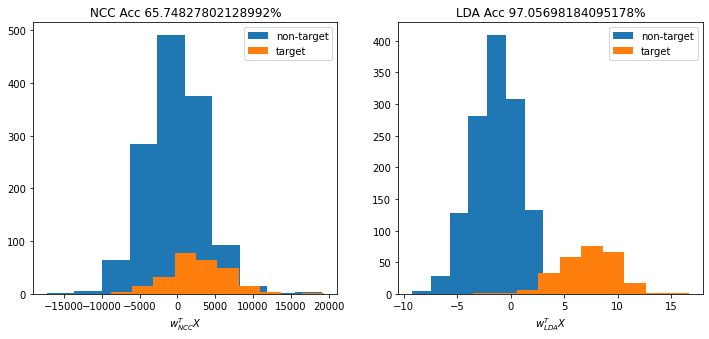

In [ ]:
compare_classifiers()

In [ ]:
def crossvalidate(X,Y,f=10,trainfunction=train_lda):
    samples = X.shape[1]
    per_bold_samples = [samples//f for i in range(f)]
    remainder = samples - samples//f*f
    for i in range(remainder):
      per_bold_samples[i]+=1
    lower = 0
    upper = 0
    acc_train = []
    acc_test = []
    for i in range(f):
      upper += per_bold_samples[i] 
      X_train = np.concatenate((X[:,:lower],X[:,upper:]),axis = 1)
      X_test = X[:,lower:upper]
      y_train = np.concatenate((Y[:lower],Y[upper:]))
      y_test = Y[lower:upper]
      w,b = trainfunction(X_train,y_train)
      acc_train.append(sp.sum(sp.sign(w.dot(X_train)-b)==y_train)*100/X_train.shape[-1])
      acc_test.append(sp.sum(sp.sign(w.dot(X_test)-b)==y_test)*100/X_test.shape[-1])
      lower += per_bold_samples[i]
    fig = pl.figure()
    plot = fig.add_subplot()
    plot.boxplot((acc_train,acc_test),labels = ('train block','test block'))
    plot.set_ylabel('Accuracy')

    return acc_train,acc_test


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: scipy.reshape is deprecated and will be removed in SciPy 2.0.0, use numpy.reshape instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: scipy.sign is deprecated and will be removed in SciPy 2.0.0, use numpy.sign instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.sign is deprecated and will be removed in SciPy 2.0.0, use numpy.sign instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: scipy.sign is deprecated and will be removed in SciPy 2.0.0, use numpy.sign instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, us

([97.74483190645229,
  97.82835665065775,
  97.93319415448852,
  97.84968684759916,
  97.68267223382045,
  97.74530271398747,
  97.59916492693111,
  97.59916492693111,
  97.82881002087683,
  97.62004175365344],
 [95.49718574108817,
  95.87242026266416,
  94.92481203007519,
  96.80451127819549,
  96.61654135338345,
  96.61654135338345,
  98.1203007518797,
  97.36842105263158,
  97.55639097744361,
  98.30827067669173])

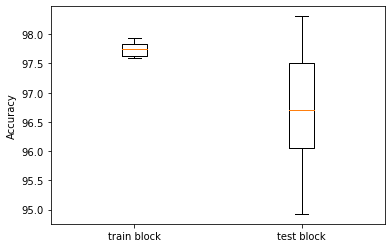

In [ ]:
X,Y = load_data('bcidata.mat')
crossvalidate(X,Y,f=10,trainfunction=train_lda)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: scipy.reshape is deprecated and will be removed in SciPy 2.0.0, use numpy.reshape instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: scipy.sign is deprecated and will be removed in SciPy 2.0.0, use numpy.sign instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.sign is deprecated and will be removed in SciPy 2.0.0, use numpy.sign instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: scipy.sign is deprecated and will be removed in SciPy 2.0.0, use numpy.sign instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, us

([65.5251618291919,
  65.60868657339736,
  65.78288100208768,
  65.86638830897704,
  65.8455114822547,
  66.05427974947808,
  65.34446764091858,
  65.5741127348643,
  65.76200417536535,
  65.44885177453027],
 [66.04127579737336,
  62.10131332082552,
  64.09774436090225,
  64.66165413533835,
  66.35338345864662,
  65.22556390977444,
  66.72932330827068,
  67.66917293233082,
  65.97744360902256,
  68.98496240601504])

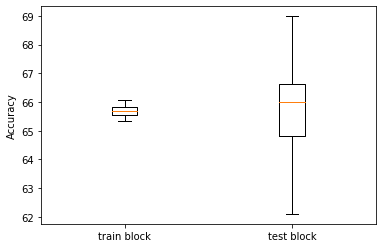

In [ ]:
X,Y = load_data('bcidata.mat')
crossvalidate(X,Y,f=10,trainfunction=train_ncc)